In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
The token `PatchTST token` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-crede

In [ ]:
!git clone https://github.com/KimMeen/Time-LLM.git

Cloning into 'Time-LLM'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 189 (delta 0), reused 1 (delta 0), pack-reused 186 (from 1)
Receiving objects: 100% (189/189), 1.09 MiB | 53.27 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [ ]:
%cd Time-LLM/layers

/content/Time-LLM/layers


In [ ]:
%cd ..

/content/Time-LLM


In [ ]:
TimeLLM=r'''
from math import sqrt

import torch
import torch.nn as nn

from transformers import LlamaConfig, LlamaModel, LlamaTokenizer, GPT2Config, GPT2Model, GPT2Tokenizer, BertConfig, \
    BertModel, BertTokenizer
from layers.Embed import PatchEmbedding
# from layers.patchtst_embedding import PatchTSTEmbedding
import transformers
from layers.StandardNorm import Normalize

transformers.logging.set_verbosity_error()


class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x


class Model(nn.Module):

    def __init__(self, configs, patch_len=16, stride=8):
        super(Model, self).__init__()
        self.task_name = configs.task_name
        self.pred_len = configs.pred_len
        self.seq_len = configs.seq_len
        self.d_ff = configs.d_ff
        self.top_k = 5
        self.d_llm = configs.llm_dim
        self.patch_len = configs.patch_len
        self.stride = configs.stride

        if configs.llm_model == 'LLAMA':
            # self.llama_config = LlamaConfig.from_pretrained('/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/')
            self.llama_config = LlamaConfig.from_pretrained('huggyllama/llama-7b')
            self.llama_config.num_hidden_layers = configs.llm_layers
            self.llama_config.output_attentions = True
            self.llama_config.output_hidden_states = True
            try:
                self.llm_model = LlamaModel.from_pretrained(
                    # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/",
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=True,
                    config=self.llama_config,
                    #load_in_4bit=True
                )
            except EnvironmentError:  # downloads model from HF is not already done
                print("Local model files not found. Attempting to download...")
                self.llm_model = LlamaModel.from_pretrained(
                    # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/",
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=False,
                    config=self.llama_config,
                    #load_in_4bit=True
                )
            try:
                self.tokenizer = LlamaTokenizer.from_pretrained(
                    # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/tokenizer.model",
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=True
                )
            except EnvironmentError:  # downloads the tokenizer from HF if not already done
                print("Local tokenizer files not found. Atempting to download them..")
                self.tokenizer = LlamaTokenizer.from_pretrained(
                    # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/tokenizer.model",
                    'huggyllama/llama-7b',
                    trust_remote_code=True,
                    local_files_only=False
                )
        # ... inside __init__ ...
        elif configs.llm_model == 'LLAMA3.2':
            # 1. Update the Model ID
            model_id = 'meta-llama/Llama-3.2-1B'  # Or 'unsloth/Llama-3.2-1B' if you don't have gated access

            # 2. Use AutoConfig/AutoModel to be safe, or stick to LlamaConfig if you prefer
            self.llama_config = LlamaConfig.from_pretrained(model_id)
            self.llama_config.num_hidden_layers = configs.llm_layers
            self.llama_config.output_attentions = True
            self.llama_config.output_hidden_states = True

            self.llm_model = LlamaModel.from_pretrained(
                model_id,
                trust_remote_code=True,
                local_files_only=False,
                config=self.llama_config,
            )

            # 3. CRITICAL: Use AutoTokenizer for Llama 3.2
            from transformers import AutoTokenizer
            self.tokenizer = AutoTokenizer.from_pretrained(
                model_id,
                trust_remote_code=True,
                local_files_only=False
            )

            # Llama 3.2 requires setting the pad token if it's missing
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
        elif configs.llm_model == 'GPT2':
            self.gpt2_config = GPT2Config.from_pretrained('openai-community/gpt2')

            self.gpt2_config.num_hidden_layers = configs.llm_layers
            self.gpt2_config.output_attentions = True
            self.gpt2_config.output_hidden_states = True
            try:
                self.llm_model = GPT2Model.from_pretrained(
                    'openai-community/gpt2',
                    trust_remote_code=True,
                    local_files_only=True,
                    config=self.gpt2_config,
                )
            except EnvironmentError:  # downloads model from HF is not already done
                print("Local model files not found. Attempting to download...")
                self.llm_model = GPT2Model.from_pretrained(
                    'openai-community/gpt2',
                    trust_remote_code=True,
                    local_files_only=False,
                    config=self.gpt2_config,
                )

            try:
                self.tokenizer = GPT2Tokenizer.from_pretrained(
                    'openai-community/gpt2',
                    trust_remote_code=True,
                    local_files_only=True
                )
            except EnvironmentError:  # downloads the tokenizer from HF if not already done
                print("Local tokenizer files not found. Atempting to download them..")
                self.tokenizer = GPT2Tokenizer.from_pretrained(
                    'openai-community/gpt2',
                    trust_remote_code=True,
                    local_files_only=False
                )
        elif configs.llm_model == 'BERT':
            self.bert_config = BertConfig.from_pretrained('google-bert/bert-base-uncased')

            self.bert_config.num_hidden_layers = configs.llm_layers
            self.bert_config.output_attentions = True
            self.bert_config.output_hidden_states = True
            try:
                self.llm_model = BertModel.from_pretrained(
                    'google-bert/bert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=True,
                    config=self.bert_config,
                )
            except EnvironmentError:  # downloads model from HF is not already done
                print("Local model files not found. Attempting to download...")
                self.llm_model = BertModel.from_pretrained(
                    'google-bert/bert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=False,
                    config=self.bert_config,
                )

            try:
                self.tokenizer = BertTokenizer.from_pretrained(
                    'google-bert/bert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=True
                )
            except EnvironmentError:  # downloads the tokenizer from HF if not already done
                print("Local tokenizer files not found. Atempting to download them..")
                self.tokenizer = BertTokenizer.from_pretrained(
                    'google-bert/bert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=False
                )
        else:
            raise Exception('LLM model is not defined')

        if self.tokenizer.eos_token:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            pad_token = '[PAD]'
            self.tokenizer.add_special_tokens({'pad_token': pad_token})
            self.tokenizer.pad_token = pad_token

        for param in self.llm_model.parameters():
            param.requires_grad = False

        if configs.prompt_domain:
            self.description = configs.content
        else:
            self.description = 'The Electricity Transformer Temperature (ETT) is a crucial indicator in the electric power long-term deployment.'

        self.dropout = nn.Dropout(configs.dropout)

        self.patch_embedding = PatchEmbedding(configs.d_model, self.patch_len, self.stride, configs.dropout)

        self.word_embeddings = self.llm_model.get_input_embeddings().weight
        self.vocab_size = self.word_embeddings.shape[0]
        self.num_tokens = 1000
        self.mapping_layer = nn.Linear(self.vocab_size, self.num_tokens)

        self.reprogramming_layer = ReprogrammingLayer(configs.d_model, configs.n_heads, self.d_ff, self.d_llm)

        self.patch_nums = int((configs.seq_len - self.patch_len) / self.stride + 2)
        self.head_nf = self.d_ff * self.patch_nums

        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            # self.output_projection = FlattenHead(configs.enc_in, self.head_nf, self.pred_len,
            #                                      head_dropout=configs.dropout)
            self.output_projection = FlattenHead(
                configs.enc_in, self.head_nf, self.pred_len, head_dropout=configs.dropout
            )
        else:
            raise NotImplementedError

        self.normalize_layers = Normalize(configs.enc_in, affine=False)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
            return dec_out[:, -self.pred_len:, :]
        return None

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):

        x_enc = self.normalize_layers(x_enc, 'norm')

        B, T, N = x_enc.size()
        x_enc = x_enc.permute(0, 2, 1).contiguous().reshape(B * N, T, 1)

        min_values = torch.min(x_enc, dim=1)[0]
        max_values = torch.max(x_enc, dim=1)[0]
        medians = torch.median(x_enc, dim=1).values
        lags = self.calcute_lags(x_enc)
        trends = x_enc.diff(dim=1).sum(dim=1)

        prompt = []
        for b in range(x_enc.shape[0]):
            min_values_str = str(min_values[b].tolist()[0])
            max_values_str = str(max_values[b].tolist()[0])
            median_values_str = str(medians[b].tolist()[0])
            lags_values_str = str(lags[b].tolist())
            prompt_ = (
                f"<|start_prompt|>Dataset description: {self.description}"
                f"Task description: forecast the next {str(self.pred_len)} steps given the previous {str(self.seq_len)} steps information; "
                "Input statistics: "
                f"min value {min_values_str}, "
                f"max value {max_values_str}, "
                f"median value {median_values_str}, "
                f"the trend of input is {'upward' if trends[b] > 0 else 'downward'}, "
                f"top 5 lags are : {lags_values_str}<|<end_prompt>|>"
            )

            prompt.append(prompt_)

        x_enc = x_enc.reshape(B, N, T).permute(0, 2, 1).contiguous()

        prompt = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048).input_ids
        prompt_embeddings = self.llm_model.get_input_embeddings()(prompt.to(x_enc.device))  # (batch, prompt_token, dim)

        source_embeddings = self.mapping_layer(self.word_embeddings.permute(1, 0)).permute(1, 0)

        x_enc = x_enc.permute(0, 2, 1).contiguous()
        #======================================================================
        #enc_out, n_vars = self.patch_embedding(x_enc.to(torch.bfloat16))
        enc_out, n_vars = self.patch_embedding(x_enc)
        #======================================================================
        enc_out = self.reprogramming_layer(enc_out, source_embeddings, source_embeddings)
        llama_enc_out = torch.cat([prompt_embeddings, enc_out], dim=1)
        dec_out = self.llm_model(inputs_embeds=llama_enc_out).last_hidden_state
        dec_out = dec_out[:, :, :self.d_ff]

        dec_out = torch.reshape(
            dec_out, (-1, n_vars, dec_out.shape[-2], dec_out.shape[-1]))
        dec_out = dec_out.permute(0, 1, 3, 2).contiguous()

        dec_out = self.output_projection(dec_out[:, :, :, -self.patch_nums:])
        dec_out = dec_out.permute(0, 2, 1).contiguous()

        dec_out = self.normalize_layers(dec_out, 'denorm')

        return dec_out

    def calcute_lags(self, x_enc):
        q_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)
        mean_value = torch.mean(corr, dim=1)
        _, lags = torch.topk(mean_value, self.top_k, dim=-1)
        return lags


class ReprogrammingLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, attention_dropout=0.1):
        super(ReprogrammingLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)

        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.value_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.out_projection = nn.Linear(d_keys * n_heads, d_llm)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, target_embedding, source_embedding, value_embedding):
        B, L, _ = target_embedding.shape
        S, _ = source_embedding.shape
        H = self.n_heads

        target_embedding = self.query_projection(target_embedding).view(B, L, H, -1)
        source_embedding = self.key_projection(source_embedding).view(S, H, -1)
        value_embedding = self.value_projection(value_embedding).view(S, H, -1)

        out = self.reprogramming(target_embedding, source_embedding, value_embedding)

        out = out.reshape(B, L, -1)

        return self.out_projection(out)

    def reprogramming(self, target_embedding, source_embedding, value_embedding):
        B, L, H, E = target_embedding.shape

        scale = 1. / sqrt(E)

        scores = torch.einsum("blhe,she->bhls", target_embedding, source_embedding)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        reprogramming_embedding = torch.einsum("bhls,she->blhe", A, value_embedding)

        return reprogramming_embedding
'''


with open("./models/TimeLLM.py", "w") as f:
    f.write(TimeLLM)

In [ ]:
!pip install -i https://pypi.org/simple/ bitsandbytes

Looking in indexes: https://pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 39.5 MB/s eta 0:00:00


In [ ]:
!cp /content/drive/MyDrive/2025Fall_LLM/Final/weather_20min.csv ./dataset

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer

from models.TimeLLM import Model
from types import SimpleNamespace

from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

from tqdm.notebook import tqdm

import random
import os
import numpy as np
import torch

def fix_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Ensure deterministic behavior for cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed fixed to {seed}")

fix_seed(2021)

# ======================
# 0. Global settings
# ======================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---- Super-speed toggle ----
SUPER_SPEED = False   # <--- set to False for full training

# ---- Dataset choice ----
DATASET_PATH = "dataset/weather_20min.csv"   # change to ETTh1.csv / Traffic.csv / Weather.csv ...

# ---- Training hyperparams (base) ----
BASE_EPOCHS = 10
WARMUP_EPOCHS = 2

BASE_BATCH_SIZE = 4
GRAD_ACCUM_STEPS = 4

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-3

FREEZETST = False

CHECKPOINT_DIR = "/content/drive/MyDrive/2025Fall_LLM/Final/PatchWise_checkpoints"

PATCHTST_CKPT = "/content/drive/MyDrive/2025Fall_LLM/Final/PatchTST_pretrained_pth/patchtst_pretrained_cw512_patch16_stride8_epochs-pretrain20_mask0.4_model1.pth"

if SUPER_SPEED:
    EPOCHS = 1
    BATCH_SIZE = 4
    MAX_TRAIN_SAMPLES = 512     # per split
    MAX_VAL_SAMPLES = 256
    MAX_TEST_SAMPLES = 256
    MAX_TRAIN_BATCHES = 5
    MAX_VAL_BATCHES = 2
    MAX_TEST_BATCHES = 2
else:
    EPOCHS = BASE_EPOCHS
    BATCH_SIZE = BASE_BATCH_SIZE
    MAX_TRAIN_SAMPLES = None
    MAX_VAL_SAMPLES = None
    MAX_TEST_SAMPLES = None
    MAX_TRAIN_BATCHES = None
    MAX_VAL_BATCHES = None
    MAX_TEST_BATCHES = None


# ======================
# 1. Small utilities
# ======================

def infer_enc_in(csv_path: str) -> int:
    """
    Infer number of covariates from a CSV file.
    Assumes first column is 'date' and the rest are features.
    """
    df = pd.read_csv(csv_path, nrows=1)
    return df.shape[1] - 1  # minus 'date' column


def time_features(dates: pd.DataFrame, freq: str = 'h'):
    """
    Creates time-based features from a pandas DataFrame of dates.
    freq:
      'h' = hourly
      't' = minutely / 10-min (Weather, ETTm)
    """
    dates = dates.copy()
    dates['month'] = dates.date.dt.month
    dates['day'] = dates.date.dt.day
    dates['weekday'] = dates.date.dt.dayofweek
    dates['hour'] = dates.date.dt.hour
    dates['quarter'] = dates.date.dt.quarter

    if freq == 't':  # minutely / 10-min data
        dates['minute'] = dates.date.dt.minute

    if freq == 'h':
        # [month, day, weekday, hour, quarter]
        features = dates[['month', 'day', 'weekday', 'hour', 'quarter']].values
        features = features.astype(float)
        features[:, 0] /= 12.0   # month
        features[:, 1] /= 31.0   # day
        features[:, 2] /= 6.0    # weekday
        features[:, 3] /= 23.0   # hour
        features[:, 4] /= 4.0    # quarter

    elif freq == 't':
        # [month, day, weekday, hour, minute, quarter]
        features = dates[['month', 'day', 'weekday', 'hour', 'minute', 'quarter']].values
        features = features.astype(float)
        features[:, 0] /= 12.0   # month
        features[:, 1] /= 31.0   # day
        features[:, 2] /= 6.0    # weekday
        features[:, 3] /= 23.0   # hour
        features[:, 4] /= 59.0   # minute
        features[:, 5] /= 4.0    # quarter

    else:
        raise ValueError(f"Unsupported frequency: {freq}")

    return features


# ======================
# 2. Dataset (generic)
# ======================

class TSForecastDataset(Dataset):
    """
    Generic dataset compatible with TimeLLM / Autoformer style models.

    CSV format:
        - 'date' column
        - remaining columns = covariates / variables

    Returns:
    - x_enc:      [seq_len, C]   - encoder input
    - x_mark_enc: [seq_len, F]   - encoder time features
    - x_dec:      [label_len + pred_len, C] - decoder input
    - x_mark_dec: [label_len + pred_len, F] - decoder time features
    - y:          [label_len + pred_len, C] - full target window
    """
    def __init__(self, csv_path, seq_len, pred_len, label_len,
                 split="train", train_ratio=0.6, val_ratio=0.2,
                 time_freq='h'):

        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.label_len = label_len

        # --- Load Data ---
        df = pd.read_csv(csv_path)

        # --- Date Features ---
        df['date'] = pd.to_datetime(df['date'])
        data_stamp = time_features(pd.DataFrame({'date': df['date']}), freq=time_freq)
        self.data_stamp = torch.from_numpy(data_stamp).float()

        # --- Value Features ---
        values = df.iloc[:, 1:].values.astype(np.float32)
        self.data = values
        n = len(values)

        # --- Splitting ---
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        n_test = n - n_train - n_val

        if split == "train":
            border1, border2 = 0, n_train
        elif split == "val":
            border1, border2 = n_train, n_train + n_val
        elif split == "test":
            border1, border2 = n_train + n_val, n
        else:
            raise ValueError(f"Unknown split {split}")

        self.split_data = self.data[border1:border2]
        self.split_stamp = self.data_stamp[border1:border2]

        # --- Standardization (fit only on whole train) ---
        train_only_data = self.data[:n_train]
        self.mean = train_only_data.mean(axis=0, keepdims=True)
        self.std = train_only_data.std(axis=0, keepdims=True) + 1e-6

        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.split_data = (self.split_data - self.mean) / self.std

        # Effective length
        self.length = len(self.split_data) - seq_len - pred_len + 1

    def __len__(self):
        return max(self.length, 0)

    def __getitem__(self, idx):
        # Encoder window
        s_begin = idx
        s_end = s_begin + self.seq_len

        x_enc = self.split_data[s_begin:s_end]          # [seq_len, C] (np)
        x_mark_enc = self.split_stamp[s_begin:s_end]    # [seq_len, F] (tensor)

        # Decoder window
        r_begin = s_end - self.label_len
        r_end = s_end + self.pred_len

        dec_data_truth = self.split_data[r_begin:r_end]  # [label_len+pred_len, C] (np)

        # Decoder input
        dec_input_zeros = np.zeros(
            (self.pred_len, dec_data_truth.shape[1]),
            dtype=np.float32
        )
        x_dec_np = np.concatenate(
            [dec_data_truth[:self.label_len], dec_input_zeros],
            axis=0
        )

        x_mark_dec = self.split_stamp[r_begin:r_end]    # [label_len+pred_len, F]

        # Convert to tensors
        x_enc = torch.from_numpy(x_enc).float()
        x_dec = torch.from_numpy(x_dec_np).float()
        y = torch.from_numpy(dec_data_truth).float()

        return x_enc, x_mark_enc, x_dec, x_mark_dec, y


def maybe_subset(ds: Dataset, max_samples: int | None):
    if max_samples is None:
        return ds
    max_samples = min(max_samples, len(ds))
    indices = list(range(max_samples))
    return Subset(ds, indices)


def make_dataloaders(csv_path, seq_len, pred_len, label_len,
                     batch_size=32, num_workers=0):

    name = str(csv_path).lower()

    # Default: hourly
    time_freq = 'h'

    # ETTm and Weather are minutely / 10-min
    if 'ettm' in name or 'weather' in name:
        time_freq = 't'

    print(f"Detected time frequency for {csv_path}: '{time_freq}'")

    train_ds = TSForecastDataset(csv_path, seq_len, pred_len, label_len,
                                 split="train", time_freq=time_freq)
    val_ds   = TSForecastDataset(csv_path, seq_len, pred_len, label_len,
                                 split="val", time_freq=time_freq)
    test_ds  = TSForecastDataset(csv_path, seq_len, pred_len, label_len,
                                 split="test", time_freq=time_freq)

    # ---- Super-speed: limit number of samples per split ----
    train_ds = maybe_subset(train_ds, MAX_TRAIN_SAMPLES)
    val_ds   = maybe_subset(val_ds,   MAX_VAL_SAMPLES)
    test_ds  = maybe_subset(test_ds,  MAX_TEST_SAMPLES)

    print(f"Train samples: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=batch_size,
                            shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_ds, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


# ======================
# 3. Configs & Model
# ======================

enc_in = infer_enc_in(DATASET_PATH)
print(f"Inferred enc_in = {enc_in} from {DATASET_PATH}")

configs = SimpleNamespace(
    # ===== Task setup =====
    task_name='long_term_forecast',
    enc_in=enc_in,
    pred_len=96,
    seq_len=512,
    label_len=96,

    # ===== Time-LLM backbone dims =====
    d_model=512,
    d_ff=512,
    n_heads=8,
    dropout=0.1,

    # ===== Patching =====
    patch_len=16,
    stride=8,

    # ===== LLM backend =====
    llm_model='LLAMA3.2',  # or 'GPT2', 'BERT' depending on your TimeLLM.py
    llm_layers=4,
    llm_dim=2048,
    llm_heads=32,

    # ===== Prompt / description =====
    prompt_domain=True,
    content="This weather dataset consists of data collected every 20 minutes and contains 21 distinct feature columns.\n This dataset is to explore the the Long sequence time-series forecasting (LSTF) problem on parameters such as air temperature, pressure, humidity, wind speed, and wind direction.\n The goal is to forecast future weather conditions based on past climate data.",

    # ===== PatchTST encoder hyperparams =====
    patchtst_layers=3,
    patchtst_heads=8,
    patchtst_d_ff=2048,
    freeze_patchtst=FREEZETST,
)

# # model = Model(configs).to(DEVICE).bfloat16()
model = Model(configs).to(DEVICE)

# # 1) Grab the PatchTST encoder inside your embedding
# patch_encoder = model.patch_embedding.encoder

# # 2) Load pretrained PatchTST weights
# patch_encoder = load_pretrained_patchtst_final(patch_encoder, PATCHTST_CKPT)

# # 3) Optionally freeze PatchTST so only TimeLLM + GPT2 + head train
# if getattr(configs, "freeze_patchtst", False):
#     for p in patch_encoder.parameters():
#         p.requires_grad = False



# 4) Sanity check
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen    = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable params: {trainable:,} | Frozen params: {frozen:,}")


# ======================
# 4. Training / evaluation
# ======================

def train_one_epoch(model, loader, optimizer, device, configs, epoch,
                    max_batches: int | None = None,
                    grad_accum_steps: int = 1):
    model.train()
    loss_fn = nn.MSELoss()
    total_loss = 0.0          # track *unscaled* loss for logging
    n_updates = 0             # number of optimizer updates

    loop = tqdm(loader, desc=f"Epoch {epoch:02d} [Train]", leave=False)

    optimizer.zero_grad()
    for batch_idx, (x_enc, x_mark_enc, x_dec, x_mark_dec, y) in enumerate(loop):
        x_enc = x_enc.to(device)
        x_mark_enc = x_mark_enc.to(device)
        x_dec = x_dec.to(device)
        x_mark_dec = x_mark_dec.to(device)
        y = y.to(device)

        out = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
        y_pred_part = y[:, -configs.pred_len:, :]

        loss = loss_fn(out, y_pred_part)

        # For logging: sum real loss (before scaling)
        total_loss += loss.item()

        # Scale for accumulation
        loss = loss / grad_accum_steps
        loss.backward()

        # Step every grad_accum_steps micro-batches
        do_step = ((batch_idx + 1) % grad_accum_steps == 0)

        # Also step if we're at max_batches or end of loader
        if max_batches is not None and (batch_idx + 1) >= max_batches:
            do_step = True

        if do_step:
            optimizer.step()
            optimizer.zero_grad()
            n_updates += 1

        # For display, use mean loss per micro-batch seen so far
        denom = (batch_idx + 1)
        loop.set_postfix(loss=total_loss / max(denom, 1))

        if (max_batches is not None) and (batch_idx + 1 >= max_batches):
            break

    # Return average micro-batch loss (same scale as original loss_fn)
    mean_loss = total_loss / max((batch_idx + 1), 1)
    return mean_loss


@torch.no_grad()
def evaluate(model, loader, device, configs, desc="Eval",
             max_batches: int | None = None):
    model.eval()
    mse_fn = nn.MSELoss()
    mae_fn = nn.L1Loss()

    total_mse = 0.0
    total_mae = 0.0
    n_batches = 0

    loop = tqdm(loader, desc=desc, leave=False)

    for batch_idx, (x_enc, x_mark_enc, x_dec, x_mark_dec, y) in enumerate(loop):
        x_enc = x_enc.to(device)
        x_mark_enc = x_mark_enc.to(device)
        x_dec = x_dec.to(device)
        x_mark_dec = x_mark_dec.to(device)
        y = y.to(device)

        out = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
        y_pred_part = y[:, -configs.pred_len:, :]

        mse = mse_fn(out, y_pred_part)
        mae = mae_fn(out, y_pred_part)

        total_mse += mse.item()
        total_mae += mae.item()
        n_batches += 1

        loop.set_postfix(
            mse=total_mse / max(n_batches, 1),
            mae=total_mae / max(n_batches, 1)
        )

        if (max_batches is not None) and (batch_idx + 1 >= max_batches):
            break

    mean_mse = total_mse / max(n_batches, 1)
    mean_mae = total_mae / max(n_batches, 1)
    return mean_mse, mean_mae

# ======================
# 5. Run training (Updated with Checkpointing)
# ======================

# --- 1. Setup Save Path ---
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
best_model_path = os.path.join(CHECKPOINT_DIR, "LLama_weather_ablation.pth")

# Track the best score (Lower is better for MSE)
best_val_mse = float('inf')

train_loader, val_loader, test_loader = make_dataloaders(
    DATASET_PATH,
    configs.seq_len,
    configs.pred_len,
    configs.label_len,
    batch_size=BATCH_SIZE,
    num_workers=0,
)

optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=LEARNING_RATE,
    weight_decay = WEIGHT_DECAY,
)


Random seed fixed to 2021
Inferred enc_in = 20 from dataset/weather_20min.csv


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Trainable params: 158,704,712 | Frozen params: 505,956,352
Detected time frequency for dataset/weather_20min.csv: 't'
Train samples: 15202, Val: 4662, Test: 4664


In [10]:
print(f"Starting training... Best model will be saved to: {best_model_path}")

scheduler1 = LinearLR(optimizer, start_factor=0.01, total_iters=WARMUP_EPOCHS)

scheduler2 = CosineAnnealingLR(optimizer, T_max = BASE_EPOCHS-WARMUP_EPOCHS)

print(f"Starting training with LR={LEARNING_RATE}, Weight Decay={WEIGHT_DECAY}")
print(f"Scheduler: {WARMUP_EPOCHS} epochs Warmup -> {BASE_EPOCHS-WARMUP_EPOCHS} epochs Cosine Decay")

for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    train_loss = train_one_epoch(
        model, train_loader, optimizer, DEVICE, configs, epoch,
        max_batches=MAX_TRAIN_BATCHES,
        grad_accum_steps=GRAD_ACCUM_STEPS,
    )

    scheduler = SequentialLR(
        optimizer,
        schedulers=[scheduler1, scheduler2],
        milestones=[WARMUP_EPOCHS]
    )

    # --- Validate ---
    val_mse, val_mae = evaluate(
        model, val_loader, DEVICE, configs,
        desc=f"Epoch {epoch:02d} [Val]",
        max_batches=MAX_VAL_BATCHES
    )

    current_lr = optimizer.param_groups[0]['lr']
    print(f"[Epoch {epoch:02d}] Loss: {train_loss:.4f} | Val MSE: {val_mse:.4f} | Val MAE: {val_mae:.4f} | LR: {current_lr:.6f}")

    # --- SAVE BEST MODEL LOGIC ---
    if val_mse < best_val_mse:
        print(f"  -> New best model! (Previous: {best_val_mse:.6f} -> Current: {val_mse:.6f})")
        best_val_mse = val_mse
        torch.save(model.state_dict(), best_model_path)
    else:
        print(f"  -> Validation did not improve (Best: {best_val_mse:.6f})")


# ======================
# 6. Final Test
# ======================

print("\nLoading best model weights for final testing...")
model.load_state_dict(torch.load(best_model_path))

test_mse, test_mae = evaluate(
    model, test_loader, DEVICE, configs,
    desc="Test",
    max_batches=MAX_TEST_BATCHES
)
print(f"[Test Result using Best Model] mse={test_mse:.6f}  mae={test_mae:.6f}")


Starting training... Best model will be saved to: /content/drive/MyDrive/2025Fall_LLM/Final/PatchWise_checkpoints/LLama_weather_ablation.pth
Starting training with LR=0.0001, Weight Decay=0.005
Scheduler: 2 epochs Warmup -> 8 epochs Cosine Decay


Epoch 01 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 01 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 01] Loss: 0.6776 | Val MSE: 0.5674 | Val MAE: 0.4494 | LR: 0.000001
  -> New best model! (Previous: inf -> Current: 0.567377)


Epoch 02 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 02 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 02] Loss: 0.5084 | Val MSE: 0.5124 | Val MAE: 0.4019 | LR: 0.000001
  -> New best model! (Previous: 0.567377 -> Current: 0.512415)


Epoch 03 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 03 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 03] Loss: 0.4870 | Val MSE: 0.5024 | Val MAE: 0.3915 | LR: 0.000001
  -> New best model! (Previous: 0.512415 -> Current: 0.502450)


Epoch 04 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 04 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 04] Loss: 0.4792 | Val MSE: 0.4929 | Val MAE: 0.3802 | LR: 0.000001
  -> New best model! (Previous: 0.502450 -> Current: 0.492939)


Epoch 05 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 05 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 05] Loss: 0.4754 | Val MSE: 0.4945 | Val MAE: 0.3850 | LR: 0.000001
  -> Validation did not improve (Best: 0.492939)


Epoch 06 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 06 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 06] Loss: 0.4729 | Val MSE: 0.4916 | Val MAE: 0.3781 | LR: 0.000001
  -> New best model! (Previous: 0.492939 -> Current: 0.491644)


Epoch 07 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 07 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 07] Loss: 0.4715 | Val MSE: 0.4910 | Val MAE: 0.3791 | LR: 0.000001
  -> New best model! (Previous: 0.491644 -> Current: 0.490987)


Epoch 08 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 08 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 08] Loss: 0.4698 | Val MSE: 0.4869 | Val MAE: 0.3750 | LR: 0.000001
  -> New best model! (Previous: 0.490987 -> Current: 0.486940)


Epoch 09 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 09 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 09] Loss: 0.4687 | Val MSE: 0.4928 | Val MAE: 0.3838 | LR: 0.000001
  -> Validation did not improve (Best: 0.486940)


Epoch 10 [Train]:   0%|          | 0/3801 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/1166 [00:00<?, ?it/s]

[Epoch 10] Loss: 0.4674 | Val MSE: 0.4910 | Val MAE: 0.3835 | LR: 0.000001
  -> Validation did not improve (Best: 0.486940)

Loading best model weights for final testing...


Test:   0%|          | 0/1166 [00:00<?, ?it/s]

[Test Result using Best Model] mse=0.219452  mae=0.273493


In [11]:
# print("\nLoading best model weights for final testing...")
# model.load_state_dict(torch.load(best_model_path))

# test_mse, test_mae = evaluate(
#     model, test_loader, DEVICE, configs,
#     desc="Test",
#     max_batches=MAX_TEST_BATCHES
# )
# print(f"[Test Result using Best Model] mse={test_mse:.6f}  mae={test_mae:.6f}")

In [15]:
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_predictions(model, loader, device, configs,
                     sample_idx: int = 0,
                     var_idx: int = 0):
    """
    Plot one example from the loader:
      - last `label_len` points of history (ground truth)
      - next `pred_len` points of ground truth
      - next `pred_len` points of model prediction

    sample_idx: which item in the batch to visualize (0..batch_size-1)
    var_idx:    which variable/channel to visualize (0..enc_in-1)
    """
    model.eval()

    # ---- Get a single batch from the loader ----
    for x_enc, x_mark_enc, x_dec, x_mark_dec, y in loader:
        x_enc = x_enc.to(device)
        x_mark_enc = x_mark_enc.to(device)
        x_dec = x_dec.to(device)
        x_mark_dec = x_mark_dec.to(device)
        y = y.to(device)
        out = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
        break  # only need the first batch

    # Move to CPU numpy
    # y shape: [B, label_len + pred_len, C]
    # out shape: [B, pred_len, C]
    y_np = y[sample_idx].detach().cpu().numpy()           # [label_len+pred_len, C]
    out_np = out[sample_idx].detach().cpu().numpy()       # [pred_len, C]

    # ---- Split into history + future ----
    L = configs.label_len
    P = configs.pred_len

    history = y_np[:L, var_idx]           # label_len history
    true_future = y_np[L:, var_idx]       # pred_len ground truth
    pred_future = out_np[:, var_idx]      # pred_len prediction

    # Time axes: history is negative, future is non-negative
    t_hist = np.arange(-L, 0)
    t_future = np.arange(0, P)

    plt.figure(figsize=(10, 4))
    # History (GT)
    plt.plot(t_hist, history, label="History (GT)", linestyle="--")
    # Future GT
    plt.plot(t_future, true_future, label="Future (GT)")
    # Future prediction
    plt.plot(t_future, pred_future, label="Future (Pred)", alpha=0.8)

    plt.axvline(0, color="black", linewidth=1)
    plt.title(f"Weather prediction")
    plt.xlabel("Time steps (0 = forecast start)")
    plt.ylabel("Normalized value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


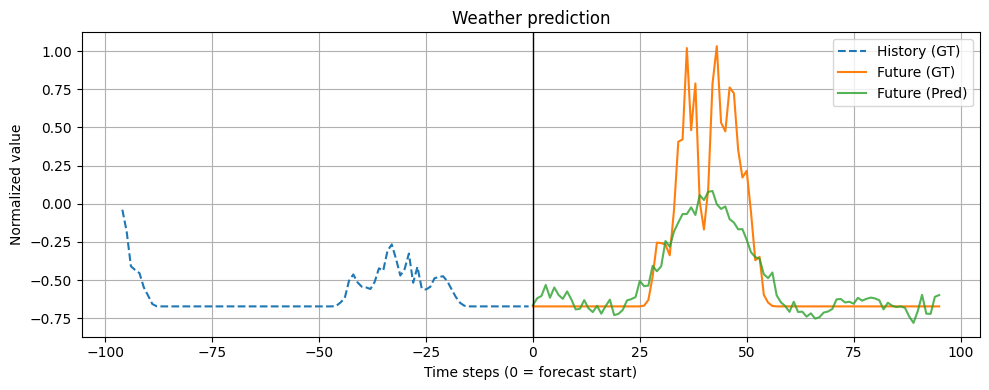

In [16]:
plot_predictions(model, test_loader, DEVICE, configs,
                 sample_idx=1,  # which series in the batch
                 var_idx=16)     # which channel (0..enc_in-1)

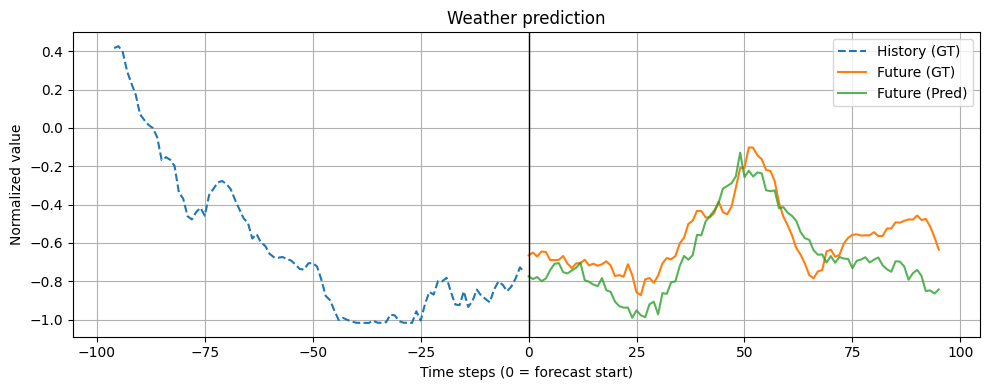

In [21]:
plot_predictions(model, test_loader, DEVICE, configs,
                 sample_idx=0,  # which series in the batch
                 var_idx=7)     # which channel (0..enc_in-1)